# Dealing with outliers

Adapted from Christian Forssen, TALENT Course 11, June 2019, with revisions by Dick Furnstahl.

## Example: good data / bad data

**Linear regression with data outliers**

Adapted from the blog post [Frequentism and Bayesianism II: When Results Differ](http://jakevdp.github.io/blog/2014/06/06/frequentism-and-bayesianism-2-when-results-differ/) 

### Import Python modules

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# Not really needed, but nicer plots
import seaborn as sns; sns.set(); sns.set_context("talk")

import emcee
import corner

One situation where the concept of nuisance parameters can be helpful is accounting for outliers in data. Consider the following dataset, relating the observed variables $x$ and $y$, with the error of $y$ stored in $e$.

In [2]:
x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])
sig0 = 3.
e = sig0*np.ones_like(y)

We'll visualize this data below:

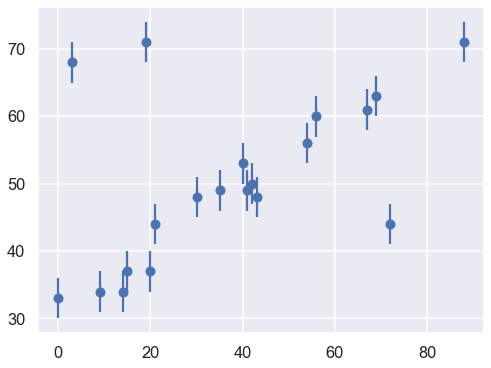

In [3]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, e, fmt='o');

Our task is to find a line of best-fit to the data. It's clear upon visual inspection that there are some outliers among these points, but let's start with a simple non-robust maximum likelihood approach. 

## The Model

We follow the procedure outlined in [parameter_estimation_fitting_straight_line_I.ipynb](../Parameter_estimation/parameter_estimation_fitting_straight_line_I.ipynb).

Thus, we're fitting a straight line to data ("$M$" here stands for "Model"), 

$$
y_M(x) = \theta_1 x + \theta_0
$$

where our parameter vector will be 

$$
\theta = [\theta_0, \theta_1].
$$

But this is only half the picture: what we mean by a "model" in a Bayesian sense is not only this expected value $y_M(x;\theta)$, but a **probability distribution** for our data.
That is, we need an expression to compute the likelihood $p(D\mid\theta)$ for our data as a function of the parameters $\theta$.

Here we are given data with simple error bars, which imply that the probability for any *single* data point is a normal distribution about the true value. In this example, the errors are specified by a single parameter $\sigma_0$. That is,

$$
y_i \sim \mathcal{N}(y_M(x_i;\theta), \sigma_0^2)
$$

or, in other words,

$$
p(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(\frac{-\left[y_i - y_M(x_i;\theta)\right]^2}{2\sigma_0^2}\right)
$$
The (known) variance of the measurement errors, $\sigma_0$, is indicated by the error bars.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
p(D\mid\theta, I) = \prod_{i=1}^N p(y_i\mid x_i,\theta, I)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:
$$\begin{align}
\log p(D\mid\theta, I) &= -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\sigma_0^2) + \frac{\left[ y_i - y_M(x_i;\theta)\right]^2}{\sigma_0^2}\right) \\
&= \text{constant} - \sum_{i=1}^N \frac{\left[ y_i - y_M(x_i;\theta)\right]^2}{2 \sigma_0^2}
\end{align}$$

We often define the *residuals*

$$
R_i = \left[ y_i - y_M(x_i;\theta) \right]/\sigma_0,
$$

so that the relevant chi-square sum is $\chi^2 =  \sum_{i=1}^N R_i^2$.

In [4]:
def residuals(theta, x=x, y=y, sigma0=sig0):
    delta_y = y - theta[0] - theta[1] * x
    return delta_y / sigma0

# Standard likelihood with Gaussian errors as specified
#  with uniform prior assumed for theta
def log_posterior_gaussian(theta):
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf    

The summation term that appears in this log-likelihood is often known as the *loss function*.  This particular loss function is known as a *squared loss* or *chi-squared*; but as you can see it can be derived from the Gaussian log likelihood.

### Standard Likelihood Approach

We can maximize the likelihood (or, equivalently, minimize the loss) to find $\theta$ within a frequentist paradigm. For a flat prior in $\theta$, the maximum of the Bayesian posterior will yield the same result. (Note that there are good arguments based on the principle of maximum entropy that a flat prior is not the best choice here; we'll ignore that detail for now, as it's a small effect for this problem. More later!)

For simplicity, we'll use scipy's ``optimize`` package to minimize the loss (in the case of squared loss, this computation can be done more efficiently using matrix methods, but we'll use numerical minimization for simplicity here).

MLE: theta0 = 41.2, theta1 = 0.25


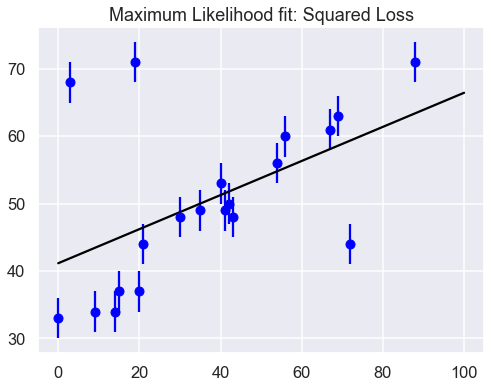

In [5]:
from scipy import optimize

def squared_loss(theta, x=x, y=y, sigma0=sig0):
    """Loss function is sum of squared residuals divided by 2, which
        is what we usually call chi^2 / 2. 
    """
    delta_y = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)
print(f"MLE: theta0 = {theta_MLE[0]:.1f}, theta1 = {theta_MLE[1]:.2f}")

xfit = np.linspace(0, 100)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(x, y, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Squared Loss');

It's clear on examination that the **outliers are exerting a disproportionate influence on the fit**. This is due to the nature of the squared loss function. If you have a single outlier that is, say 10 standard deviations away from the fit, its contribution to the loss will out-weigh that of 25 points which are 2 standard deviations away!

Clearly the squared loss is overly sensitive to outliers, and this is causing issues with our fit. One way to address this within the frequentist paradigm is to simply adjust the loss function to be more robust.

### Frequentist Correction for Outliers: Huber Loss

The variety of possible loss functions is quite literally infinite, but one relatively well-motivated option is the [Huber loss](http://en.wikipedia.org/wiki/Huber_loss_function). The Huber loss defines a critical value at which the loss curve transitions from quadratic to linear. Let's create a plot which compares the Huber loss to the standard squared loss for several critical values $c$:

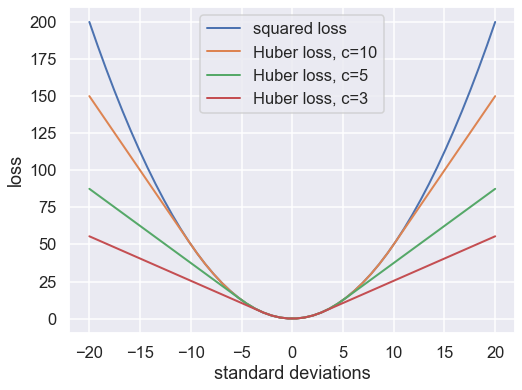

In [6]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    plt.plot(t, huber_loss(t, c), label=f"Huber loss, c={c}", lw=2)
ax.set(ylabel='loss', xlabel='standard deviations')
plt.legend(loc='best');

The Huber loss is equivalent to the squared loss for points which are well-fit by the model, but reduces the loss contribution of outliers. For example, a point 20 standard deviations from the fit has a squared loss of 200, but a c=3 Huber loss of just over 55. Let's see the result of the best-fit line using the Huber loss rather than the squared loss. We'll plot the squared loss result as a dashed gray line for comparison:

Huber: theta0 = 34.9, theta1 = 0.38


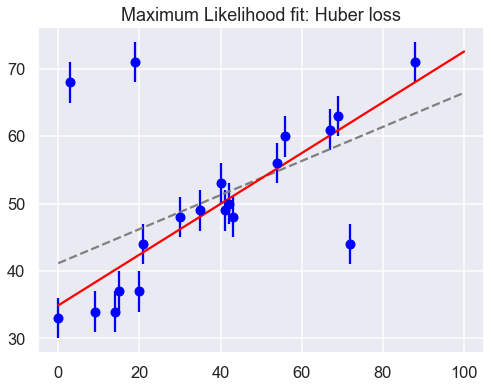

In [7]:
def total_huber_loss(theta, x=x, y=y, sigma0=sig0, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / sigma0, c).sum()

theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
print(f"Huber: theta0 = {theta2[0]:.1f}, theta1 = {theta2[1]:.2f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='red')
plt.title('Maximum Likelihood fit: Huber loss');

By eye, this seems to have worked as desired: the fit is much closer to our intuition!

However a Bayesian might point out that the motivation for this new loss function is a bit suspect: as we showed, the squared-loss can be straightforwardly derived from a Gaussian likelihood. The Huber loss seems a bit *ad hoc*: where does it come from? How should we decide what value of $c$ to use? Is there any good motivation for using a linear loss on outliers, or should we simply remove them instead? How might this choice affect our resulting model?

## Bayesian approaches to erratic data

1. A conservative model (treat all data points as equally possible outliers).
1. Good-and-bad data model.
1. The Cauchy formulation.
1. Many nuisance parameters.

## Bayesian Approach to Outliers #1: A conservative formulation

Assuming that the specified error bars, $\sigma_0$, can be viewed as a recommended lower bound, we can construct a more conservative posterior through a marginal likelihood (note that $\sigma_0$ doesn't appear in the first pdf in the integrand and $\theta$ doesn't appear in the second pdf),

$$
p(D_i|\theta, \sigma_0, I) = \int_0^\infty p(D_i|\theta,\sigma,I) \, p(\sigma|\sigma_0) \, d\sigma,
$$

with the prior being a variant of Jeffrey's prior for a scale parameter (which would be $1/\log(\sigma_1/\sigma_0) \times (1/\sigma)$ for $\sigma_0 \leq \sigma < \sigma_1$ and zero otherwise),

$$
p(\sigma|\sigma_0,I) = \frac{\sigma_0}{\sigma^2},
$$

for $\sigma \geq \sigma_0$ and zero otherwise. (This enables us to do the integral up to infinity.) Conservative here means that we treat all data points with suspicion.

The likelihood for a single data point $D_i$, given by $(x_i,y_i,\sigma_i=\sigma_0)$, is then

$$\begin{align}
p(D_i | \theta, \sigma_0, I) &= 
  \int_{\sigma_0}^{\infty} \frac{1}{\sqrt{2\pi}\sigma}
    e^{-\sigma_0^2 R_i^2/2\sigma^2}\, \frac{\sigma_0}{\sigma^2}\, d\sigma
  \\
 &= \frac{\sigma_0}{\sqrt{2\pi}}\int_0^{1/\sigma_0}
   t \, e^{-t^2 \sigma_0^2 R_i^2/2}\, dt \\
 &= \frac{1}{\sigma_0\sqrt{2\pi}} \left[ \frac{1-\exp(-R_i^2/2)}{R_i^2} \right],
\end{align}$$

with $R_i$ the residual as defined above.

Treating the measurement noise as independent, and assigning a uniform prior for the model parameters, we find the log-posterior pdf
$$
\log \left[ p(\theta|D, I)\right] = \text{constant} + \sum_{i=1}^N \log \left[ \frac{1-\exp(-R_i^2/2)}{R_i^2}\right].
$$

We'll also consider a Cauchy distribution for comparison.

In [8]:
def single_gaussian_likelihood(R_i, sigma_0):
    """
    This likelihood is a zero-mean gaussian with standard deviation sigma_0.
    """
    rsq = R_i**2
    return np.exp(-rsq / 2.) / (sigma_0 * np.sqrt(2 * np.pi ))

def single_conservative_likelihood(R_i, sigma_0):
    """
    This likelihood is the result of marginalizing over the standard 
    deviation sigma from sigma0 to infinity with a prior sigma0 / sigma^2.
    """
    rsq = R_i**2
    return (1-np.exp(-rsq / 2.)) / (sigma_0 * np.sqrt(2. * np.pi) * rsq)

def single_cauchy_likelihood(R_i, sigma_0):
    """
    This likelihood is a Cauchy distribution.
    """
    rsq = R_i**2
    return 1 / (sigma_0 * np.pi * np.sqrt(2) * (1. + rsq / 2.))

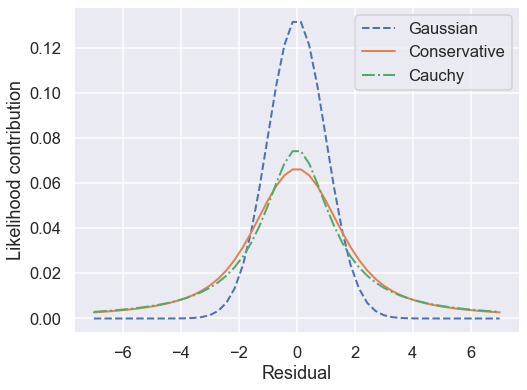

In [9]:
r = np.linspace(-7, 7)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(r, single_gaussian_likelihood(r,sig0), label="Gaussian", 
        lw=2, ls='--')
ax.plot(r, single_conservative_likelihood(r,sig0), label="Conservative", 
        lw=2, ls='-')
ax.plot(r, single_cauchy_likelihood(r,sig0), label="Cauchy", 
        lw=2, ls='-.')
ax.set(ylabel='Likelihood contribution',xlabel='Residual')
plt.legend(loc='best');

In [10]:
# Conservative error likelihood
def log_posterior_conservative(theta):
    # uniform prior for theta, Gaussian likelihood
    if (all(theta > 0) and all(theta < 100)):
        r2 = residuals(theta)**2
        return np.sum( np.log((1-np.exp(-r2/2))/r2) )
    else:
        return -np.inf  # recall log(0) = -inf    

Now we can sample using this conservative posterior and compare to the others.

## Bayesian Approach to Outliers #2: Good-and-bad data

See Sivia, Ch. 8.3.2

In this approach, we are less pessimistic about the data.  In particular, we allow for two possibilities: <br>
a) the datum and its error are reliable; <br>
b) the datum is bad and the error should be larger by a (large) factor $\gamma$.

We implement this with the pdf for $\sigma$:

$$
  p(\sigma | \sigma_0, \beta, \gamma, I) = \beta\, \delta(\sigma - \gamma\sigma_0) + (1-\beta)\, \delta(\sigma - \sigma_0) \;,
$$

where $\beta$ and $\gamma$ represent the frequency of quirky measurements and their severity.  If we use Gaussian pdfs for the two cases, then the likelihood for a datum $D_i$ after integrating over $\sigma$ is

$$
 p(D_i | \theta, \sigma_0, \beta, \gamma, I) = \frac{1}{\sigma_0 \sqrt{2\pi}} 
   \left\{ \frac{\beta}{\gamma}\, e^{-R_i^2/2\gamma^2} + (1-\beta)\, e^{-R_i^2/2}  \right\}
$$

We won't code this approach here but leave it to an exercise.  We will generalize the idea to the extreme in approach #4 below.  

## Bayesian Approach to Outliers #3: The Cauchy formulation

In this approach, we assume $\sigma \approx \sigma_0$ but allow it to be either narrower or wider:

$$
  p(\sigma | \sigma_0, I) = \frac{2\sigma_0}{\sqrt{\pi}\sigma^2} e^{-\sigma_0^2/\sigma^2} \;.
$$

Marginalizing $\sigma$ (using $\sigma = 1/t$) gives the Cauchy form likelihood:

$$
  p(D_i | \theta, \sigma_0, I) = \frac{1}{\sigma_0 \pi \sqrt{2} [1 + R_i^2(\theta)/2]}  \;.
$$

The log posterior is

$$
  L(\theta) = \mbox{constant} - \sum_{i=1}^N \log\left[1 + \frac{R_i^2(\theta)}{2}\right]
$$

In [11]:
# Cauchy likelihood
def log_posterior_cauchy(theta):
    # uniform prior for theta, Cauchy likelihood
    if (all(theta > 0) and all(theta < 100)):
        R_sq = residuals(theta)**2
        return - np.sum( np.log(1 + R_sq/2) )
    else:
        return -np.inf  # recall log(0) = -inf    

## Sampling

emcee sampling (version: ) 2.2.1
10 walkers:
Log posterior: Std Gaussian
... EMCEE sampler performing 1000 warnup iterations.
... EMCEE sampler performing 10000 samples.
CPU times: user 5.05 s, sys: 18.2 ms, total: 5.07 s
Wall time: 5.12 s
done


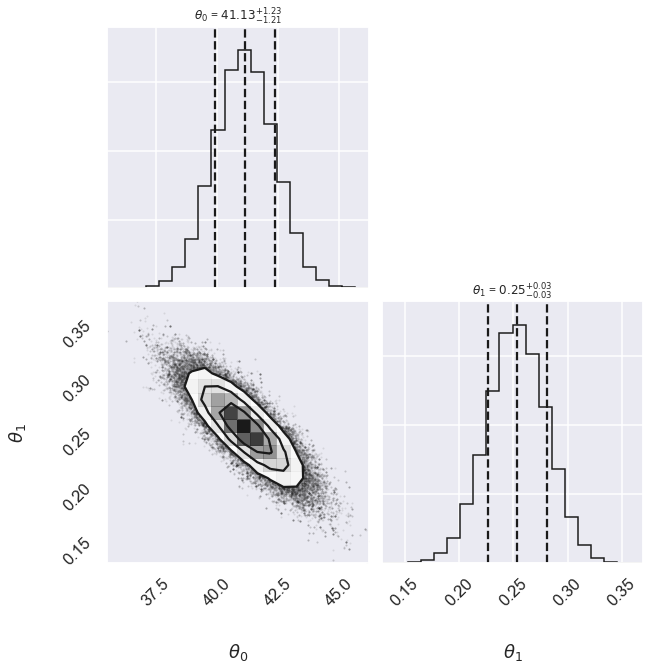

Log posterior: Conservative
... EMCEE sampler performing 1000 warnup iterations.
... EMCEE sampler performing 10000 samples.
CPU times: user 5.7 s, sys: 21.6 ms, total: 5.73 s
Wall time: 5.74 s
done


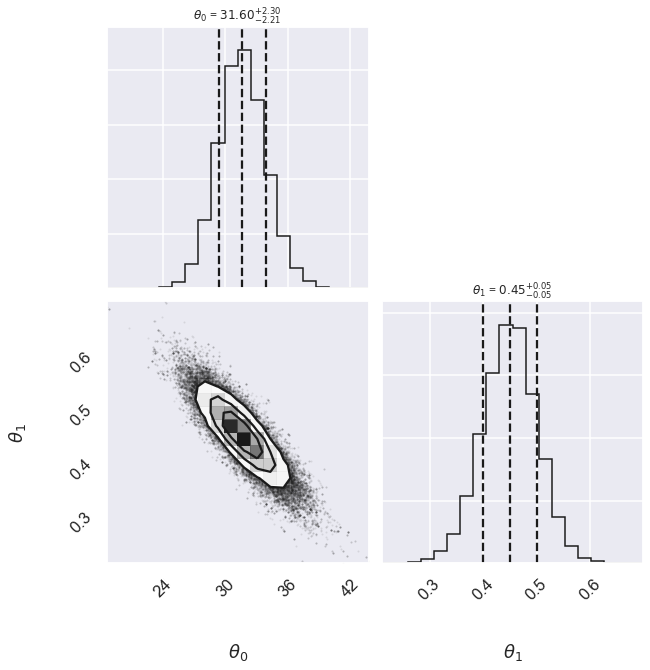

Log posterior: Cauchy
... EMCEE sampler performing 1000 warnup iterations.
... EMCEE sampler performing 10000 samples.
CPU times: user 5.54 s, sys: 19.3 ms, total: 5.56 s
Wall time: 5.58 s
done


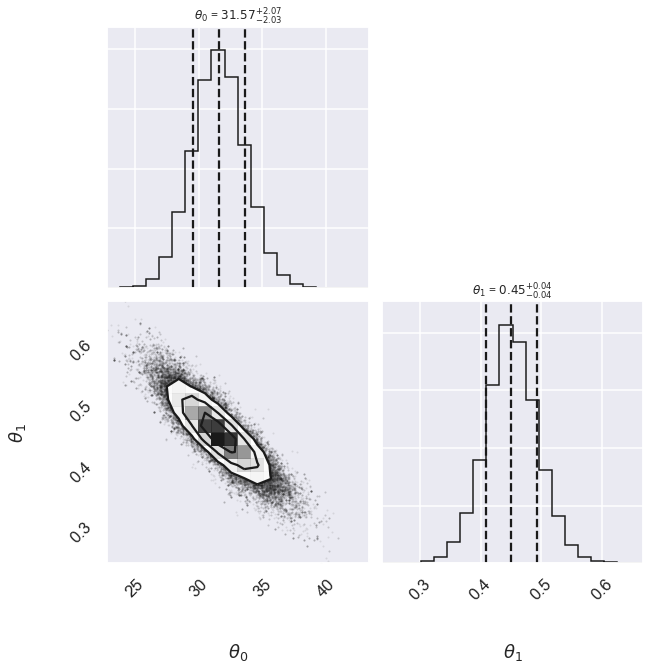

In [12]:
print('emcee sampling (version: )', emcee.__version__)

ndim = 2 # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nwarmup = 1000  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take

print(f'{nwalkers} walkers:')

# Starting guesses close to the MLE
starting_guesses = np.abs(np.random.normal(1, 1, (nwalkers, 2)))
starting_guesses[:,0] += theta_MLE[0]
starting_guesses[:,1] /= 10
starting_guesses[:,1] += theta_MLE[1]

logps = [log_posterior_gaussian, log_posterior_conservative,
         log_posterior_cauchy]
approaches = ['Std Gaussian', 'Conservative','Cauchy']
mean_68CR = []

for ilogp,logp in enumerate(logps):
    print(f"Log posterior: {approaches[ilogp]}")
    # Sample the posterior distribution
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logp)

    # Warm-up
    if nwarmup > 0:
        print(f'... EMCEE sampler performing {nwarmup} warnup iterations.')
        pos, prob, state = sampler.run_mcmc(starting_guesses, nwarmup)
        sampler.reset()
    else:
        pos = starting_guesses
    
    # Perform iterations, starting at the final position from the warmup.
    print(f'... EMCEE sampler performing {nsteps} samples.')
    %time sampler.run_mcmc(pos, nsteps)
    print("done")

    samples = sampler.flatchain
    lnposts = sampler.lnprobability
    
    # Extract mean and 68% CR
    th0_mcmc, th1_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
    mean_68CR.append((th0_mcmc,th1_mcmc))
    
    # make a corner plot with the posterior distribution
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    corner.corner(samples,labels=[r"$\theta_0$", r"$\theta_1$"],
                       quantiles=[0.16, 0.5, 0.84],fig=fig,
                       show_titles=True, title_kwargs={"fontsize": 12});
    plt.show()

Summary:             Mean offset  68% CR     Mean slope     68% CR
        Std Gaussian    41.13   -1.21,+1.23     0.253    -0.027,+0.027
        Conservative    31.60   -2.21,+2.30     0.451    -0.049,+0.052
              Cauchy    31.57   -2.03,+2.07     0.451    -0.043,+0.041


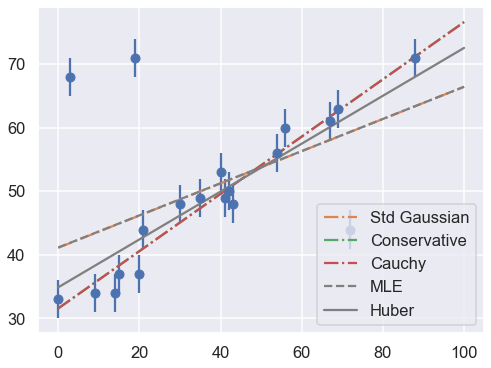

In [13]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o')

print("Summary:             Mean offset  68% CR     Mean slope     68% CR")
for i,approach in enumerate(approaches):
    ((th0,th0pos,th0neg),(th1,th1neg,th1pos)) = mean_68CR[i]
    print(f"{approach:>20s}    {th0:5.2f}   -{th0neg:4.2f},+{th0pos:4.2f}",\
         f"    {th1:5.3f}    -{th1neg:5.3f},+{th1pos:5.3f}")
    ax.plot(xfit, th0 + th1 * xfit, label=approach,  ls='-.')
    
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, 
        color='gray',ls='--',label='MLE')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, 
        color='gray',ls='-',label='Huber')
plt.legend(loc='best');

## Bayesian Approach to Outliers #4: Many nuisance parameters

The Bayesian approach to accounting for outliers generally involves *modifying the model* so that the outliers are accounted for. For this data, it is abundantly clear that a simple straight line is not a good fit to our data. So let's propose a more complicated model that has the flexibility to account for outliers. One option is to choose a mixture between a signal and a background:

$$
\begin{array}{ll}
p(\{y_i\}~|~\{x_i\}, \{e_i\},~\theta,\{g_i\},\sigma_B) = & \frac{g_i}{\sqrt{2\pi e_i^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2e_i^2}\right] \\
&+ \frac{1 - g_i}{\sqrt{2\pi \sigma_B^2}}\exp\left[\frac{-\left(\hat{y}(x_i~|~\theta) - y_i\right)^2}{2\sigma_B^2}\right]
\end{array}
$$

What we've done is expanded our model with some nuisance parameters: $\{g_i\}$ is a series of weights which range from 0 to 1 and encode for each point $i$ the degree to which it fits the model. $g_i=0$ indicates an outlier, in which case a Gaussian of width $\sigma_B$ is used in the computation of the likelihood. This $\sigma_B$ can also be a nuisance parameter, or its value can be set at a sufficiently high number, say 50.

Our model is much more complicated now: it has 22 free parameters rather than 2, but the majority of these can be considered nuisance parameters, which can be marginalized-out in the end, just as we marginalized (integrated) over $p$ in the Billiard example.  Let's construct a function which implements this likelihood. We'll use the [emcee](http://dan.iel.fm/emcee/current/) package to explore the parameter space.

To actually compute this, we'll start by defining functions describing our prior, our likelihood function, and our posterior:

In [14]:
# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i

def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e**2) - 0.5 * (dy / e)**2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B**2) \
            - 0.5 * (dy / sigma_B)**2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)

Now we'll run the MCMC sampler to explore the parameter space:

In [15]:
# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta_MLE, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[x, y, sig0, 50])
sampler.run_mcmc(starting_guesses, nsteps)

samples = sampler.chain[:, nburn:, :].reshape(-1, ndim)

/Users/furnstah/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/furnstah/anaconda3/envs/8805-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Once we have these samples, we can exploit a very nice property of the Markov chains. Because their distribution models the posterior, we can integrate out (i.e. marginalize) over nuisance parameters simply by ignoring them!

We can look at the (marginalized) distribution of slopes and intercepts by examining the first two columns of the sample:

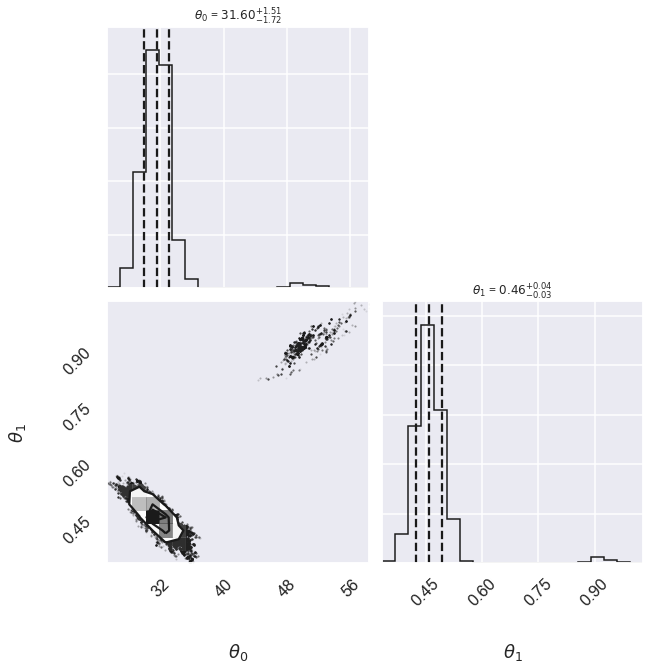

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
# plot a corner plot with the posterior distribution
# Note that the intercept and the slope correspond to 
#  the first two entries in the parameter array.
fig = corner.corner(samples[:,:2], labels=[r"$\theta_0$", r"$\theta_1$"],
                    quantiles=[0.16, 0.5, 0.84],fig=fig,
                    show_titles=True, title_kwargs={"fontsize": 12})

We see a distribution of points near a slope of $\sim 0.4-0.5$, and an intercept of $\sim 29-34$. We'll plot this model over the data below, but first let's see what other information we can extract from this trace.

One nice feature of analyzing MCMC samples is that the choice of nuisance parameters is completely symmetric: just as we can treat the $\{g_i\}$ as nuisance parameters, we can also treat the slope and intercept as nuisance parameters! Let's do this, and check the posterior for $g_1$ and $g_2$, the outlier flag for the first two points:

g1 mean: 0.62
g2 mean: 0.40


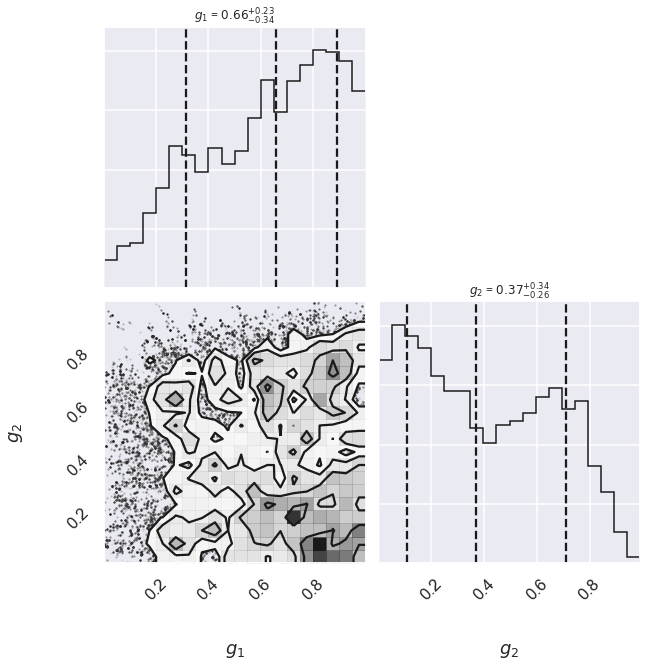

In [17]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
# plot a corner plot with the posterior distribution
# Note that the intercept and the slope correspond to 
#  the first two entries in the parameter array.
fig = corner.corner(samples[:,2:4], labels=[r"$g_1$", r"$g_2$"],
                    quantiles=[0.16, 0.5, 0.84],fig=fig,
                    show_titles=True, title_kwargs={"fontsize": 12})

print("g1 mean: {0:.2f}".format(samples[:, 2].mean()))
print("g2 mean: {0:.2f}".format(samples[:, 3].mean()))

There is not an extremely strong constraint on either of these, but we do see that $(g_1, g_2) = (1, 0)$ is slightly favored: the means of $g_1$ and $g_2$ are greater than and less than 0.5, respectively. If we choose a cutoff at $g=0.5$, our algorithm has identified $g_2$ as an outlier.

Let's make use of all this information, and plot the marginalized best model over the original data. As a bonus, we'll draw red circles to indicate which points the model detects as outliers:

In [18]:
theta3 = np.mean(samples[:, :2], 0)
g = np.mean(samples[:, 2:], 0)
outliers = (g < 0.5)

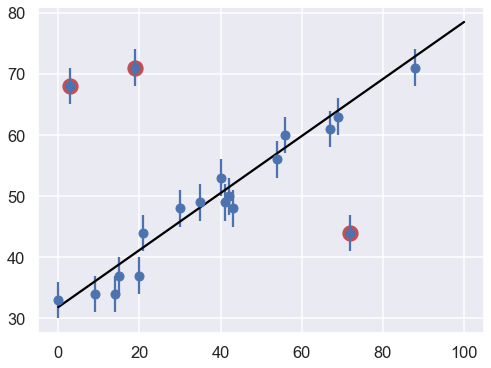

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, sig0, fmt='o')

plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.scatter(x[outliers], y[outliers], 
            marker='o', s=150, edgecolors='r', linewidths=4, c='k');

The result, shown by the dark line, matches our intuition! Furthermore, the points automatically identified as outliers are the ones we would identify by hand.  For comparison, the gray lines show the two previous approaches: the simple maximum likelihood and the frequentist approach based on Huber loss.

### Discussion

Here we've dived into linear regression in the presence of outliers. A typical Gaussian maximum likelihood approach fails to account for the outliers, but we were able to correct this in the frequentist paradigm by modifying the loss function, and in the Bayesian paradigm by adopting a mixture model with a large number of nuisance parameters.

Both approaches have their advantages and disadvantages: the frequentist approach here is relatively straightforward and computationally efficient, but is based on the use of a loss function which is not particularly well-motivated. The Bayesian approach is well-founded and produces very nice results, but requires a rather subjective specification of a prior. It is also much more intensive in both coding time and computational time.